In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
df_tran = pd.read_csv('../dataset/tran.txt',names=['primary-date','time','approximate-indicator','secondary-date','approximate-indicator',
  'transaction-ID','player','type','from-team','from-league','to-team','to-league','draft-type','draft-round','pick-number','info'])
df_playerid = pd.read_csv('../dataset/playerid_list.csv',names=['LASTNAME','FIRSTNAME','PLAYERID','DAVENPORTCODE','MLBCODE','player'],skiprows=1);
df_master = pd.read_csv('../dataset/Master.csv')
df_batstat = pd.read_csv('../dataset/war_daily_bat.txt')
df_pitchstat = pd.read_csv('../dataset/war_daily_pitch.txt')
pd.set_option('display.max_columns', 60)

# Data Cleanup
# Recontructing invalid dates
df_tran['primary-date'] = df_tran['primary-date'].astype('str')
df_tran['primary-date'] = df_tran['primary-date'].str.replace(r'\A(\d{4})[0]{4}', r'\g<1>0101')
df_tran['primary-date'] = df_tran['primary-date'].str.replace(r'\A(\d{4})(..)[0]{2}', r'\g<1>\g<2>01')

#Extracting only trades from transaction dataframe
df_tran = df_tran[df_tran['type'] == "T "]
df_tran = df_tran[df_tran['to-league'].isin(['AL','NL'])]
df_tran = df_tran[df_tran['from-league'].isin(['AL','NL'])]

df_tran['primary-date'] = pd.to_datetime(df_tran['primary-date'], format='%Y%m%d')
df_tran['tranYear'] = df_tran['primary-date'].apply(lambda x : int(x.year))

C:\Users\arpith\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2723: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [133]:
df_tran['transaction-ID'].nunique()

5622

In [48]:
import networkx as nx
import operator
G =nx.Graph()
for index, row in df_tran.iterrows():
    G.add_edge(row['from-team'] ,row['to-team']) 

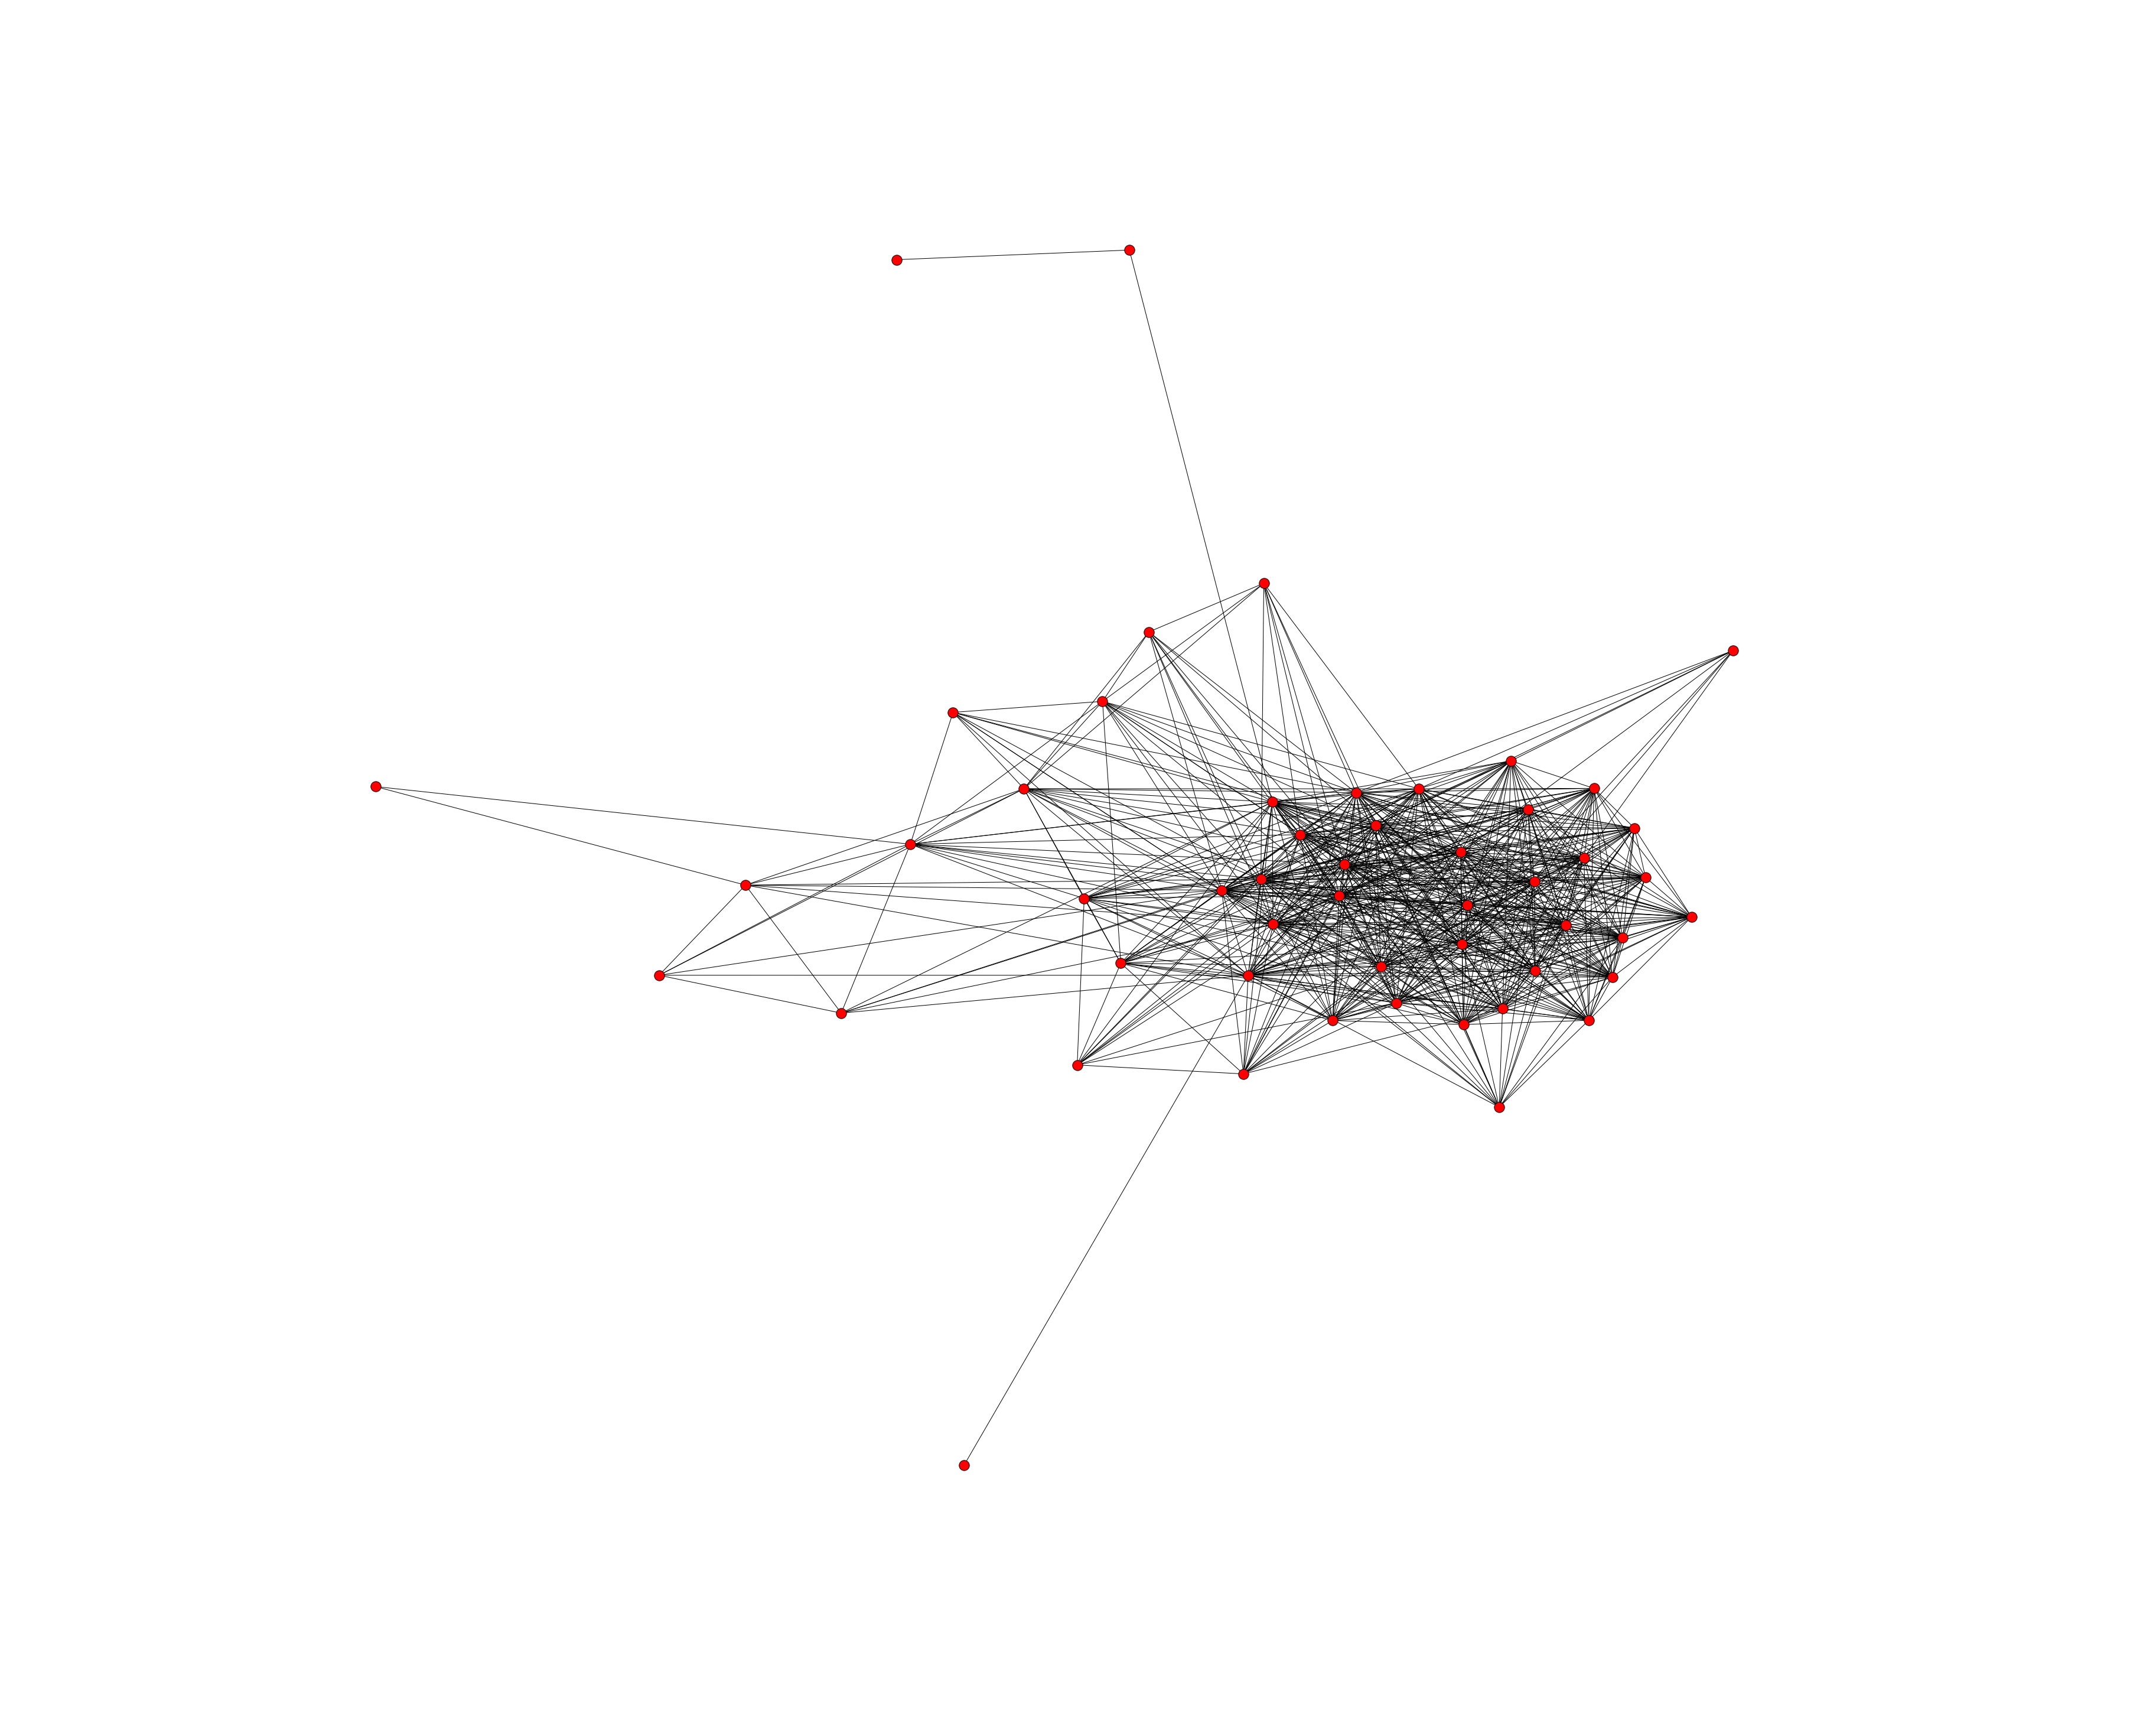

In [49]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline 
fig = plt.figure (figsize=(50,40))
nx.draw(G,pos=nx.spring_layout(G))
plt.savefig('graph.png')

In [50]:
df_tran_ANL = df_tran[(df_tran['to-league'] == 'AL') & (df_tran['from-league'] == 'AL')]
df_tran_ANL['transaction-ID'].nunique()

1518

In [51]:
df_tran_ANL = df_tran[(df_tran['to-league'] == 'NL') & (df_tran['from-league'] == 'NL')]
df_tran_ANL['transaction-ID'].nunique()

1789

In [52]:
df_tran_ANL = df_tran[(df_tran['to-league'] == 'AL') & (df_tran['from-league'] == 'NL')]
df_tran_ANL['transaction-ID'].nunique()

2346

In [53]:
df_tran_ANL = df_tran[(df_tran['to-league'] == 'NL') & (df_tran['from-league'] == 'AL')]
df_tran_ANL['transaction-ID'].nunique()

2348

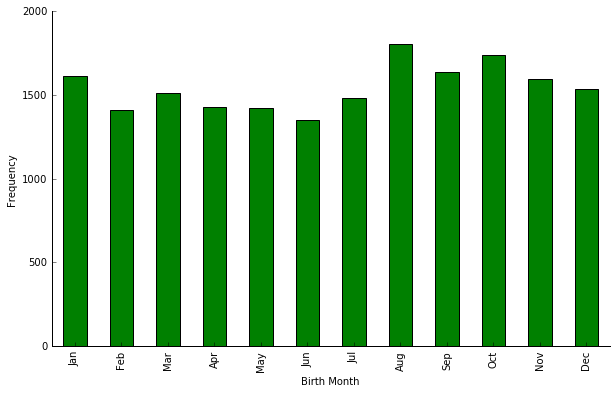

In [134]:
# Birthday Skew
fig = plt.figure(figsize=(10, 6))
 
ax = plt.subplot(111) 

ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)  
  
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left()   
numBins = 50
x = df_master['birthMonth']
x = x.dropna()

plt.xlabel("Birth Month")
plt.ylabel("Frequency")

order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul','Aug','Sep','Oct','Nov','Dec']
x = x.apply(lambda x : order[int(x)-1])

# Draw the bar chart
x.value_counts().ix[order].plot(ax=ax, kind='bar',color='green')
plt.savefig('birth.png')
plt.show()

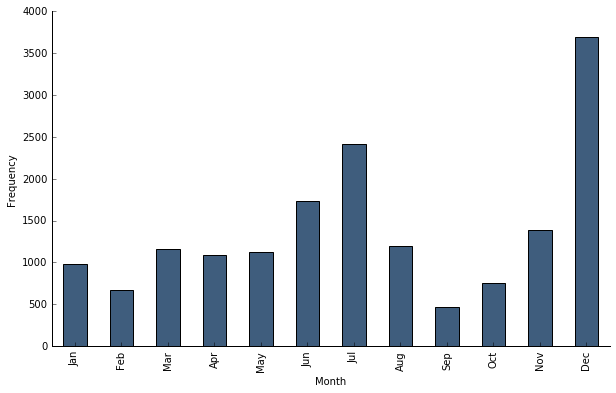

In [135]:
# month where most transactions take place

df_ttime = df_tran['primary-date']
df_ttime = df_ttime.dropna()
df_ttime= df_ttime.apply(lambda x : x.strftime('%b'))

fig = plt.figure(figsize=(10, 6))
 
ax = plt.subplot(111) 

ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)  
  
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left()   

plt.xlabel("Month")
plt.ylabel("Frequency")



order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul','Aug','Sep','Oct','Nov','Dec']

# Draw the bar chart
df_ttime.value_counts().ix[order].plot(ax=ax, kind='bar',color='#3F5D7D')
#ax.hist(df_ttime,numBins,color='green')
plt.savefig('trans.png')
plt.show()

In [136]:
# age at which player gets traded
df_master_year = df_master[['birthYear','retroID']]
df_master_year=  df_master_year.rename(columns = {'retroID':'player'})
df_master_year = df_master_year.dropna()
df_merged = pd.merge(df_tran,df_master_year,on='player',how='inner')
df_merged['Difference'] = df_merged['tranYear'].sub(df_merged['birthYear'], axis=0)

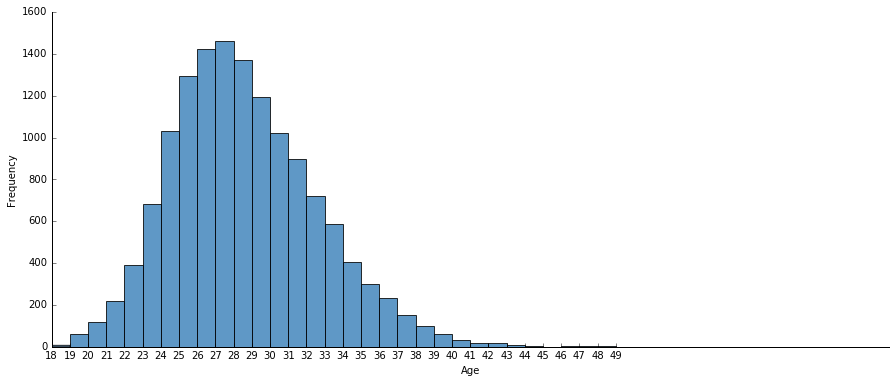

In [137]:
fig = plt.figure(figsize=(15, 6))
 
ax = plt.subplot(111) 

ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)  
  
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left()   

x = df_merged['Difference']
x = x.dropna()
numBins = int(max(x) - min(x))
x = x.apply(lambda x : int(x))
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.xticks(range(0,50))
ax.hist(x,numBins,color='#377eb8',alpha=0.8)
plt.savefig('age.png')
plt.show()

In [138]:
# effect of experience on trade veterens vs prospects
df_master_dyear = df_master[['debut','retroID']]
df_master_dyear=df_master_dyear.rename(columns = {'retroID':'player'})
df_master_dyear = df_master_dyear.dropna()
df_master_dyear['debut'] = pd.to_datetime(df_master_dyear['debut'], format='%Y-%m-%d',errors = 'coerce')
df_master_dyear['debut'] = df_master_dyear['debut'].apply(lambda x : x.year)
df_merged = pd.merge(df_tran,df_master_dyear,on='player',how='inner')
df_merged['Difference'] = df_merged['tranYear'].sub(df_merged['debut'], axis=0)

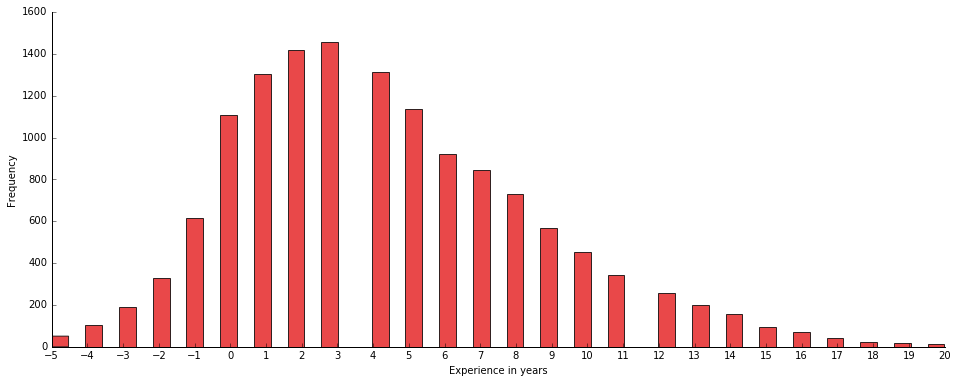

In [139]:
fig = plt.figure(figsize=(16, 6))
 
ax = plt.subplot(111) 

ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)  
  
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left()   

x = df_merged['Difference']
x = x.dropna()
numBins = int(max(x) - min(x))
x = x.apply(lambda x : int(x))
plt.xlabel("Experience in years")
plt.ylabel("Frequency")
plt.xticks(range(-7,28))
ax.hist(x,numBins,color='#e41a1c',alpha=0.8, range=[-5, 20])
plt.savefig('exp.png')
plt.show()

Baseline Mddel

In [9]:
df_master['player_ID'] = df_master['bbrefID']
df_batstat = pd.merge(df_batstat,df_master[['player_ID','retroID']],on='player_ID',how='inner')
df_pitchstat = pd.merge(df_batstat,df_master[['player_ID','retroID']],on='player_ID',how='inner')

In [169]:
df_tran.head()

,primary-date,time,approximate-indicator,secondary-date,approximate-indicator,transaction-ID,player,type,from-team,from-league,to-team,to-league,draft-type,draft-round,pick-number,info,tranYear
32372,1968-12-10,NaN,NaN,NaN,NaN,72232,marel101,T,DET,AL,HOU,NL,NaN,NaN,NaN,NaN,1968
32373,1967-08-17,NaN,NaN,NaN,NaN,72232,mathe101,T,HOU,NL,DET,AL,NaN,NaN,NaN,NaN,1967
32374,1967-11-22,NaN,NaN,NaN,NaN,72232,gladf102,T,DET,AL,HOU,NL,NaN,NaN,NaN,NaN,1967
50583,1964-01-01,NaN,NaN,NaN,NaN,72241,steem101,T,CHN,NL,PHI,NL,NaN,NaN,NaN,NaN,1964
50584,1964-01-01,NaN,NaN,NaN,NaN,72241,Robert Baillargeon,T,PHI,NL,CHN,NL,NaN,NaN,NaN,NaN,1964


In [158]:
df_batstat.head()

,name_common,age,mlb_ID,player_ID,year_ID,team_ID,stint_ID,lg_ID,PA,G,Inn,runs_bat,runs_br,runs_dp,runs_field,runs_infield,runs_outfield,runs_catcher,runs_good_plays,runs_defense,runs_position,runs_position_p,runs_replacement,runs_above_rep,runs_above_avg,runs_above_avg_off,runs_above_avg_def,WAA,WAA_off,WAA_def,WAR,WAR_def,WAR_off,WAR_rep,salary,pitcher,teamRpG,oppRpG,oppRpPA_rep,oppRpG_rep,pyth_exponent,pyth_exponent_rep,waa_win_perc,waa_win_perc_off,waa_win_perc_def,waa_win_perc_rep,OPS_plus,TOB_lg,TB_lg,retroID
0,David Aardsma,22.0,430911.0,aardsda01,2004,SFG,1,NL,0,11,10.7,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.05,0.00,0.0,0.1,0.1,0.1,0.1,0.01,0.01,0.00,0.01,0.00,0.01,0.0,300000.0,Y,4.67546,4.67092,0.08651,4.67092,1.891,1.890,0.5005,0.5005,0.5005,0.5000,NaN,0.000,0.000,aardd001
1,David Aardsma,24.0,430911.0,aardsda01,2006,CHC,1,NL,3,45,53.0,-0.90,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.21,0.46,0.0,-0.2,-0.2,-0.2,0.2,-0.02,-0.02,0.00,-0.02,0.00,-0.02,0.0,NaN,Y,4.86164,4.86675,0.09085,4.86467,1.912,1.913,0.4995,0.4995,0.5005,0.4998,-100.0,0.694,0.896,aardd001
2,David Aardsma,25.0,430911.0,aardsda01,2007,CHW,1,AL,0,25,32.3,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.11,0.00,0.0,0.1,0.1,0.1,0.1,0.01,0.01,0.02,0.01,0.02,0.01,0.0,387500.0,Y,4.86335,4.85895,0.08422,4.85895,1.912,1.912,0.5004,0.5004,0.5004,0.5000,NaN,0.000,0.000,aardd001
3,David Aardsma,26.0,430911.0,aardsda01,2008,BOS,1,AL,1,47,48.7,-0.29,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.22,0.14,0.0,0.1,0.1,0.1,0.2,0.00,0.00,0.05,0.00,0.05,0.00,0.0,403250.0,Y,4.70549,4.70400,0.08092,4.70321,1.894,1.894,0.5001,0.5001,0.5005,0.4999,-100.0,0.345,0.434,aardd001
4,David Aardsma,27.0,430911.0,aardsda01,2009,SEA,1,AL,0,73,71.3,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.32,0.00,0.0,0.3,0.3,0.3,0.3,0.03,0.03,0.06,0.03,0.06,0.03,0.0,419000.0,Y,4.80227,4.79788,0.08302,4.79788,1.905,1.905,0.5004,0.5004,0.5004,0.5000,NaN,0.000,0.000,aardd001


In [30]:
df_batstat[df_batstat['player_ID'] =='brookmi01']

,name_common,age,mlb_ID,player_ID,year_ID,team_ID,stint_ID,lg_ID,PA,G,Inn,runs_bat,runs_br,runs_dp,runs_field,runs_infield,runs_outfield,runs_catcher,runs_good_plays,runs_defense,runs_position,runs_position_p,runs_replacement,runs_above_rep,runs_above_avg,runs_above_avg_off,runs_above_avg_def,WAA,WAA_off,WAA_def,WAR,WAR_def,WAR_off,WAR_rep,salary,pitcher,teamRpG,oppRpG,oppRpPA_rep,oppRpG_rep,pyth_exponent,pyth_exponent_rep,waa_win_perc,waa_win_perc_off,waa_win_perc_def,waa_win_perc_rep,OPS_plus,TOB_lg,TB_lg,retroID


In [31]:
#Calculates the absolute difference between two sides of a trade by summing the WAR values of each player on each side
def trade_value(tranID):
    td = df_tran[(df_tran['transaction-ID'] == tranID)]
    teams = td['from-team'].unique()
    val = 0
    player_vals = []
    for x in teams:
        for index, row in td.iterrows():
            val = 0
            if (row['from-team'] == x):
                if pd.isnull(row['player']):
                    # filter out cash transactions or yet to be named player transaction 
                    continue
                player_df = df_batstat[(df_batstat['retroID'] == row['player'])]
                player_df_year = player_df[(df_batstat['year_ID'] == row['tranYear'])]
                if not player_df_year.empty:
                    val += float(player_df_year['WAR'].iloc[0])
                elif not player_df.empty:
                    # take a random value if we don't have war for that transaction year, put logic to change this to nearest year
                    val += float(player_df['WAR'].iloc[0])
                else:
                    ## figure out a way to find war for these players
                    print(str(row['player']) + " :" + str(row['tranYear']))
                    val += 0
        player_vals.append(val)
    return abs(player_vals[1]-player_vals[0])

#Making a list of the above function returns for each transaction to plot it in next cell
trade_val_list = []
transactions = df_tran['transaction-ID'].unique()
for x in transactions:
    trade_val_list.append(trade_value(x))

C:\Users\arpith\Anaconda3\lib\site-packages\ipykernel\__main__.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Robert Baillargeon :1964
James Ward :1912
Arthur Duchesnil :1913
Bob Parham :1932
George Savino :1935
Bernard Cobb :1937
Stan Keyes :1937
Wes Livengood :1939
Charles Glock :1939
Arthur Luce :1940
Harold Sieling :1940
John Pintar :1940
Jack Burman :1941
Barney Lutz :1944
Fred Harrington :1949
George Byam :1949
Rocco Ippolito :1949
Donald Robertson :1950
Bob Landeck :1951
Jake Schmitt :1951
George McPhail :1952
Dick Kinaman :1952
Charles Sipple :1952
Bobby Wilson :1952
Bobby Wilson :1953
Norman Fox :1953
Larry Lassalle :1953
Emil Tellinger :1954
Jim Post :1954
Theodore Del Guercio :1954
John Jancse :1954
Harry Schwegman :1954
Al Curtis :1955
Jim Frey :1956
Wally Lammers :1956
Melvin Geho :1957
Leonard Williams :1957
Pete Mesa :1958
Ben Mateosky :1958
winkb801 :1958
John Turk :1958
Emil Panko :1959
Dick Hanlon :1959
Alfred Paschal :1959
Robert Sagers :1959
Bill Lajoie :1960
Chuck Staniland :1959
Alex Cosmidis :1959
Bud Watkins :1960
Richard Sanders :1960
Lee Handley :1960
Frederick Hopke 

<function matplotlib.pyplot.show>

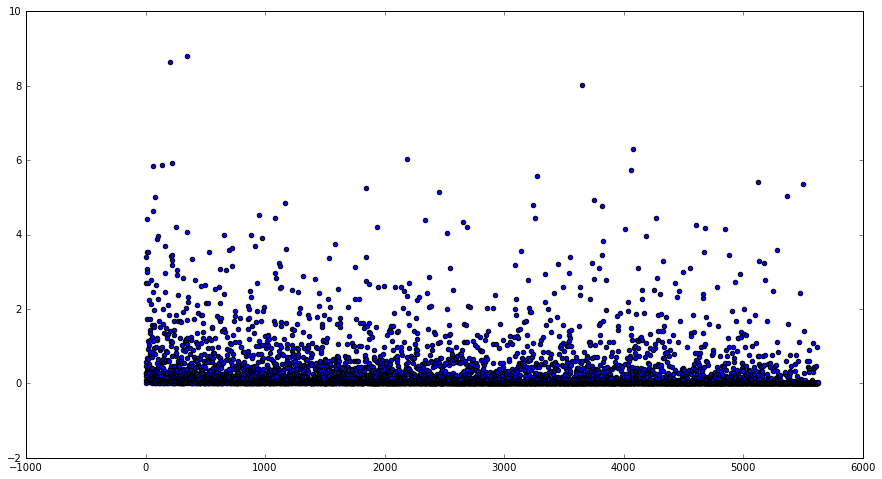

In [32]:
#trade_val_list
x_pos = np.arange(0,len(trade_val_list))
plt.figure(figsize=(15, 8))
plt.scatter(x_pos, trade_val_list)
plt.show

In [33]:
len(trade_val_list)

5622